# Dota 2 Match Outcome Prediction  

This project explores the relationship between hero selection and match outcomes in Dota 2, focusing on the unique abilities, synergies, and counters of each hero. By analyzing historical match data and leveraging machine learning, the goal is to predict match outcomes and provide insights into how hero picks impact a team's chances of success.

---

### Goals  

1. **Analyze Hero Interactions**: Examine how heroes interact through counters and synergies, as well as the influence of win rates on match outcomes.  
2. **Predict Match Results**: Develop a machine learning model to predict match winners based on hero selections alone.  
3. **Identify Key Features**: Determine which factors—such as win rate differences, counter-matchups, or team synergy—play the biggest role in shaping outcomes.  

---

### Key Points  

- The analysis focuses on **hero picks and their interactions**, emphasizing the role of counters and team synergy.  
- Predictions are based solely on hero data and do not account for external factors like player skill, strategy, or in-game dynamics.  
- The project aims to uncover how much information hero data alone provides about match outcomes.  

---

### Approach  

1. **Data Collection**  
   - Match data was analyzed to calculate hero-specific metrics, such as win rates, counters, and synergies. These metrics were derived from historical matches, ensuring they were customized and up-to-date for this project.  
   - Data was gathered using the [OpenDota API](https://docs.opendota.com/) to source raw match information.  

2. **Data Processing**  
   - Processed match data with techniques like scaling and imputation to clean and standardize inputs.  
   - Engineered features like win rate differences, matchup scores, and synergy scores to capture the complexity of hero interactions.  

3. **Modeling**  
   - Developed predictive models, including Random Forest, Gradient Boosting and Logistic Regression, to forecast match outcomes.  
   - The models incorporated **hero counters** and **team synergies** as key inputs, alongside win rates, to improve accuracy.  

4. **Evaluation and Optimization**  
   - Evaluated model performance using metrics like accuracy and confidence scores.  
   - Fine-tuned model parameters through hyperparameter optimization to enhance predictions.  

---

### Results and Insights  

The project highlights the significant role of hero selection in Dota 2 matches, offering insights into how counters and synergies influence outcomes. While predictions cannot account for external factors like player skill, the models provide a solid foundation for understanding the strategic importance of hero picks.  

In [ ]:
!pip install pandas numpy matplotlib plotly seaborn scikit-learn --quiet

In [ ]:
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
pd.set_option('display.max_columns', None)

To skip API fetching, scroll down to the section titled **"Load Preprocessed Data"**.


## Data Source

The project utilizes the **OpenDota API** for gathering data to analyze hero interactions and match outcomes. Two key endpoints are used:

```python
# Fetch hero data (ID and names)
response = requests.get("https://api.opendota.com/api/heroStats")

# Fetch match data
response = requests.get("https://api.opendota.com/api/publicMatches")
```

### Overview:
1. **Hero Data**:
   - Collect hero IDs and localized names.
   - Use this data to build matrices for synergies (how well heroes perform together) and counters (how effective they are against specific heroes).

2. **Match Data**:
   - Fetch public matches to populate match structures, e.g.:
     ```python
     "radiant_team": heroes in the Radiant team,
     "dire_team": heroes in the Dire team,
     "radiant_win": match result.
     ```
   - Many fields (e.g., synergy and matchup scores) are initialized as `0` since the API doesn't provide them directly.
   - These values are calculated by analyzing hero interactions across multiple matches to fill the hero matrices.

This approach ensures comprehensive data processing for hero matchups and synergies, forming the basis for accurate predictions.

### Data Source: Hero Information

Hero data is fetched from the OpenDota API (`/heroStats`) to get IDs and names. This data is used to initialize matrices for hero matchups and synergies, which are populated later with match data.

In [1]:
import requests


url = "https://api.opendota.com/api/heroStats"
response = requests.get(url)

heroes = []

if response.status_code == 200:
    heroes2 = response.json()
    for hero in heroes2:
        heroes.append({"id": hero["id"], "name": hero["localized_name"], "num_games": 0, "win_games": 0})

heroes_df = pd.DataFrame(heroes)

num_heroes = len(heroes)

hero_matchups_df = pd.DataFrame(
    data=np.zeros((num_heroes, num_heroes)),
    index=[hero["id"] for hero in heroes],
    columns=[hero["id"] for hero in heroes]
)
hero_matchups_count_df = hero_matchups_df.copy()
hero_matchups = hero_matchups_df.to_dict(orient='records')
hero_matchups_count = hero_matchups_count_df.to_dict(orient='records')

hero_synergies_df = hero_matchups_df.copy()
hero_synergies_count_df = hero_synergies_df.copy()
hero_synergies = hero_synergies_df.to_dict(orient='records')
hero_synergies_count = hero_synergies_count_df.to_dict(orient='records')

### Data Source: Match Information

The script fetches match data using the OpenDota API (`/publicMatches`). The primary goal is to collect basic match attributes and store unpopulated matches for further processing. The collected attributes include:

- **Populated Attributes**:
  - `match_id`: Unique identifier for each match.
  - `radiant_team`: List of heroes on the Radiant team (if available).
  - `dire_team`: List of heroes on the Dire team (if available).
  - `radiant_win`: Indicates whether Radiant won the match.

- **Unpopulated (Defaulted to 0)**:
  - `radiant_wr`: Radiant team's win rate.
  - `dire_wr`: Dire team's win rate.
  - `radiant_matchups_score`: Radiant's matchup score based on hero counters.
  - `dire_matchups_score`: Dire's matchup score based on hero counters.
  - `radiant_synergies_score`: Radiant's synergy score based on team composition.
  - `dire_synergies_score`: Dire's synergy score based on team composition.

This step focuses on gathering raw match data, which is later enriched by calculating scores and rates based on hero performance.

In [ ]:
%%time
import requests
import pandas as pd
from time import sleep

base_url = "https://api.opendota.com/api/publicMatches"

columns = ["match_id", "radiant_team", "dire_team", "radiant_win"]
matches_df = pd.DataFrame(columns=columns)

target_matches = 200000
fetched_matches = 0
last_match_id = None

max_retries = 5

while fetched_matches < target_matches:
    params = {"less_than_match_id": last_match_id} if last_match_id else {}

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        matches = response.json()

        if not matches:
            print("No more matches to fetch.")
            break

        for match in matches:
            match_data = {
                "match_id": match["match_id"],
                "radiant_team": match.get("radiant_team", None),
                "dire_team": match.get("dire_team", None),
                "radiant_wr": 0,
                "dire_wr": 0,
                "radiant_matchups_score": 0,
                "dire_matchups_score": 0,
                "radiant_synergies_score": 0,
                "dire_synergies_score": 0,
                "radiant_win": match["radiant_win"],
            }
            matches_df = pd.concat([matches_df, pd.DataFrame([match_data])], ignore_index=True)

        last_match_id = matches[-1]["match_id"]
        fetched_matches += len(matches)

        print(f"Fetched {fetched_matches} matches...")
        sleep(1)

    elif response.status_code == 429:
        print(f"Rate limit exceeded. Retrying in 20 seconds.../or exiting")
        break #it will go on continuesly if use continue

    else:
        print(f"Error {response.status_code}: {response.text}")
        max_retries -= 1
        if max_retries == 0:
            print("Maximum retries reached. Exiting.")
            break
        sleep(10)
        continue

Fetched 100 matches...
Fetched 200 matches...
Fetched 300 matches...
Fetched 400 matches...
Fetched 500 matches...
Fetched 600 matches...
Fetched 700 matches...
Fetched 800 matches...
Fetched 900 matches...
Fetched 1000 matches...
Fetched 1100 matches...
Fetched 1200 matches...
Fetched 1300 matches...
Fetched 1400 matches...
Fetched 1500 matches...
Fetched 1600 matches...
Fetched 1700 matches...
Fetched 1800 matches...
Fetched 1900 matches...
Fetched 2000 matches...
Fetched 2100 matches...
Fetched 2200 matches...
Fetched 2300 matches...
Fetched 2400 matches...
Fetched 2500 matches...
Fetched 2600 matches...
Fetched 2700 matches...
Fetched 2800 matches...
Fetched 2900 matches...
Fetched 3000 matches...
Fetched 3100 matches...
Fetched 3200 matches...
Fetched 3300 matches...
Fetched 3400 matches...
Fetched 3500 matches...
Fetched 3600 matches...
Fetched 3700 matches...
Fetched 3800 matches...
Fetched 3900 matches...
Fetched 4000 matches...
Fetched 4100 matches...
Fetched 4200 matches...
F

### Populating Hero Matchups, Synergies, and Win Rates

In this part of the process, we populate the following data:

1. **Hero Win Rates**:
   - Track the number of games played and won for each hero.
   - Update win counts based on match outcomes (Radiant or Dire victory).

2. **Hero Matchups**:
   - Update how heroes perform against each other.
   - Populate a matrix reflecting the net score of hero interactions and the total count of matchups.

3. **Hero Synergies**:
   - Analyze how heroes perform when on the same team.
   - Update a synergy matrix to reflect win/loss contributions for team combinations and the total synergy count.

This step processes each match iteratively and updates these metrics to create a comprehensive dataset for further analysis.

In [ ]:
def update_hero_matchups(hero_matchups_df, hero_matchups_count_df, radiant_team, dire_team, radiant_win):

    for radiant_hero in radiant_team:
        for dire_hero in dire_team:
            if radiant_win:
                hero_matchups_df.loc[radiant_hero, dire_hero] += 1
                hero_matchups_df.loc[dire_hero, radiant_hero] -= 1
            else:
                hero_matchups_df.loc[radiant_hero, dire_hero] -= 1
                hero_matchups_df.loc[dire_hero, radiant_hero] += 1

            hero_matchups_count_df.loc[radiant_hero, dire_hero] += 1
            hero_matchups_count_df.loc[dire_hero, radiant_hero] += 1

In [ ]:
def update_hero_synergies(hero_synergies_df, hero_synergies_count_df, team, win):

    for hero1 in team:
        for hero2 in team:
            if hero1 != hero2:
                if win:
                    hero_synergies_df.loc[hero1, hero2] += 1
                else:
                    hero_synergies_df.loc[hero1, hero2] -= 1

                hero_synergies_count_df.loc[hero1, hero2] += 1


In [ ]:
%%time
for _, row in matches_df.iterrows():
    radiant_team = row["radiant_team"]
    dire_team = row["dire_team"]
    radiant_win = row["radiant_win"]

    for hero in radiant_team:
        heroes_df.loc[heroes_df["id"] == hero, "num_games"] += 1
        heroes_df.loc[heroes_df["id"] == hero, "win_games"] += 1 if radiant_win else 0

    for hero in dire_team:
        heroes_df.loc[heroes_df["id"] == hero, "num_games"] += 1
        heroes_df.loc[heroes_df["id"] == hero, "win_games"] += 0 if radiant_win else 1

    update_hero_matchups(hero_matchups_df, hero_matchups_count_df, radiant_team, dire_team, radiant_win)

    update_hero_synergies(hero_synergies_df, hero_synergies_count_df, radiant_team, radiant_win)
    update_hero_synergies(hero_synergies_df, hero_synergies_count_df, dire_team, not radiant_win)

    match_data = {
        "match_id": row["match_id"],
        "radiant_team": radiant_team,
        "dire_team": dire_team,

        "radiant_win": radiant_win,
    }


    # print(match_data)

CPU times: user 2h 41min 27s, sys: 56.2 s, total: 2h 42min 23s
Wall time: 2h 43min 58s


In [ ]:
hero_synergies_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,119,120,121,123,126,128,129,131,135,136,137,138,145
1,0.0,169.0,50.0,16.0,5.0,-15.0,-100.0,-3.0,-43.0,-48.0,-108.0,-2.0,-97.0,108.0,-1.0,8.0,-9.0,-10.0,-47.0,-5.0,-103.0,31.0,11.0,112.0,134.0,148.0,-19.0,58.0,149.0,327.0,19.0,0.0,0.0,-11.0,141.0,97.0,-18.0,-36.0,-41.0,-33.0,110.0,-6.0,-74.0,-25.0,-48.0,7.0,-43.0,-8.0,18.0,82.0,22.0,-77.0,34.0,-9.0,22.0,17.0,38.0,-39.0,7.0,12.0,13.0,-22.0,23.0,-47.0,-25.0,10.0,49.0,-53.0,-12.0,116.0,-39.0,16.0,-44.0,125.0,7.0,45.0,-10.0,-9.0,37.0,-11.0,-12.0,-32.0,28.0,40.0,-92.0,-33.0,86.0,1.0,-13.0,4.0,23.0,40.0,1.0,-14.0,10.0,-52.0,-58.0,-23.0,-49.0,46.0,212.0,6.0,188.0,-7.0,-33.0,-8.0,43.0,-20.0,5.0,58.0,-4.0,30.0,16.0,41.0,-47.0,-37.0,-71.0,-7.0,-1.0,-95.0,-23.0,-12.0,-32.0,-6.0,27.0,-7.0
2,169.0,0.0,16.0,49.0,115.0,293.0,-20.0,333.0,35.0,-16.0,48.0,11.0,73.0,123.0,17.0,-28.0,28.0,-15.0,-19.0,116.0,-47.0,257.0,-38.0,212.0,33.0,206.0,-9.0,10.0,340.0,597.0,23.0,-23.0,48.0,7.0,150.0,147.0,-8.0,-25.0,77.0,-42.0,134.0,10.0,145.0,17.0,-114.0,2.0,-58.0,76.0,8.0,84.0,20.0,-22.0,206.0,26.0,68.0,-9.0,11.0,45.0,19.0,105.0,93.0,42.0,67.0,-5.0,7.0,342.0,86.0,-7.0,48.0,148.0,-1.0,39.0,-4.0,338.0,119.0,30.0,-1.0,3.0,16.0,-19.0,10.0,0.0,208.0,75.0,-187.0,-14.0,57.0,-12.0,-15.0,105.0,33.0,71.0,155.0,-6.0,-12.0,-20.0,26.0,1.0,-51.0,128.0,333.0,6.0,17.0,-11.0,-7.0,1.0,20.0,-7.0,23.0,98.0,36.0,35.0,-88.0,-3.0,-4.0,33.0,-22.0,39.0,-2.0,6.0,47.0,9.0,35.0,4.0,8.0,29.0
3,50.0,16.0,0.0,25.0,18.0,12.0,20.0,4.0,-21.0,-8.0,6.0,7.0,-10.0,2.0,4.0,7.0,17.0,-4.0,-3.0,1.0,-33.0,14.0,0.0,14.0,-5.0,3.0,0.0,28.0,44.0,43.0,-2.0,4.0,-10.0,-5.0,16.0,27.0,-19.0,-28.0,8.0,-17.0,23.0,-6.0,19.0,-15.0,-1.0,5.0,-19.0,0.0,0.0,24.0,-5.0,-23.0,5.0,-6.0,-2.0,-4.0,-5.0,-5.0,19.0,15.0,0.0,-10.0,1.0,2.0,-4.0,50.0,-1.0,-5.0,17.0,-41.0,7.0,22.0,-15.0,14.0,-5.0,11.0,3.0,6.0,2.0,-5.0,7.0,7.0,-3.0,16.0,-25.0,-3.0,19.0,-8.0,3.0,-3.0,10.0,8.0,7.0,4.0,21.0,-4.0,18.0,4.0,0.0,-1.0,18.0,-8.0,17.0,-13.0,14.0,-13.0,3.0,-13.0,9.0,12.0,10.0,-2.0,-29.0,2.0,-4.0,-1.0,-19.0,-1.0,9.0,2.0,2.0,2.0,-2.0,-11.0,-1.0,-25.0
4,16.0,49.0,25.0,0.0,7.0,17.0,24.0,68.0,3.0,-12.0,-1.0,-16.0,-12.0,108.0,47.0,26.0,39.0,-10.0,-14.0,26.0,-26.0,73.0,-4.0,-13.0,96.0,63.0,-4.0,34.0,114.0,162.0,-6.0,1.0,-17.0,-42.0,6.0,68.0,-17.0,5.0,44.0,13.0,54.0,-7.0,48.0,17.0,-24.0,-8.0,-17.0,-11.0,-33.0,50.0,-4.0,-15.0,16.0,6.0,15.0,8.0,-16.0,9.0,87.0,6.0,30.0,27.0,48.0,-14.0,4.0,63.0,-4.0,21.0,28.0,4.0,-8.0,21.0,-30.0,120.0,69.0,0.0,10.0,9.0,3.0,0.0,-7.0,-14.0,105.0,41.0,27.0,11.0,48.0,-4.0,1.0,-5.0,15.0,29.0,23.0,5.0,20.0,1.0,11.0,55.0,-10.0,28.0,126.0,6.0,93.0,-50.0,25.0,14.0,39.0,-14.0,-11.0,28.0,9.0,0.0,-3.0,-8.0,-11.0,-2.0,-35.0,12.0,7.0,16.0,-3.0,45.0,16.0,-8.0,13.0,18.0
5,5.0,115.0,18.0,7.0,0.0,123.0,-42.0,248.0,-28.0,-52.0,-93.0,-41.0,-65.0,153.0,20.0,-32.0,19.0,-35.0,-38.0,33.0,-107.0,18.0,-16.0,-10.0,15.0,53.0,-30.0,17.0,66.0,100.0,-3.0,16.0,-11.0,-15.0,74.0,9.0,-23.0,-81.0,-32.0,-14.0,109.0,-29.0,-33.0,-12.0,-70.0,37.0,-13.0,-46.0,-52.0,-20.0,9.0,-103.0,51.0,23.0,1.0,-7.0,17.0,-9.0,88.0,-2.0,15.0,-5.0,19.0,-26.0,-8.0,118.0,34.0,-32.0,-7.0,27.0,-43.0,14.0,-23.0,54.0,29.0,15.0,-20.0,0.0,43.0,-24.0,-4.0,0.0,12.0,19.0,-116.0,4.0,16.0,-1.0,-3.0,0.0,39.0,12.0,88.0,-13.0,-7.0,-47.0,-16.0,-30.0,-42.0,-13.0,17.0,12.0,110.0,-17.0,-32.0,7.0,31.0,-16.0,-21.0,-10.0,-11.0,4.0,-105.0,-11.0,-17.0,-19.0,-37.0,9.0,11.0,14.0,4.0,62.0,28.0,-14.0,-1.0,24.0


In [ ]:
hero_synergies_count_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,119,120,121,123,126,128,129,131,135,136,137,138,145
1,0.0,2425.0,304.0,304.0,1667.0,347.0,2266.0,343.0,539.0,294.0,1416.0,84.0,969.0,3106.0,659.0,756.0,1035.0,174.0,933.0,1193.0,617.0,1809.0,507.0,2626.0,3638.0,1768.0,753.0,912.0,2485.0,2329.0,355.0,466.0,332.0,2243.0,1647.0,1139.0,494.0,1594.0,1051.0,161.0,1010.0,330.0,484.0,679.0,392.0,923.0,189.0,916.0,1204.0,1070.0,298.0,1021.0,296.0,177.0,406.0,205.0,366.0,635.0,979.0,418.0,937.0,502.0,1703.0,225.0,73.0,338.0,913.0,573.0,258.0,1706.0,401.0,534.0,2178.0,1443.0,733.0,275.0,120.0,519.0,267.0,443.0,162.0,442.0,2430.0,1034.0,2724.0,937.0,1358.0,49.0,255.0,404.0,327.0,314.0,393.0,106.0,804.0,1602.0,1118.0,1161.0,739.0,956.0,1186.0,200.0,2406.0,1221.0,489.0,578.0,441.0,254.0,905.0,576.0,428.0,364.0,528.0,833.0,343.0,649.0,1277.0,475.0,567.0,867.0,523.0,1048.0,554.0,330.0,355.0,561.0
2,2425.0,0.0,382.0,795.0,2307.0,3009.0,1956.0,3179.0,729.0,1738.0,2812.0,671.0,1269.0,3265.0,639.0,406.0,1396.0,337.0,811.0,1412.0,733.0,2711.0,294.0,3640.0,4867.0,2384.0,191.0,228.0,3526.0,3267.0,827.0,481.0,430.0,3485.0,1476.0,1641.0,88.0,2343.0,1329.0,1008.0,878.0,322.0,3585.0,835.0,856.0,1040.0,892.0,1122.0,1724.0,1258.0,344.0,1234.0,1308.0,116.0,602.0,223.0,445.0,743.0,143.0,433.0,1293.0,1086.0,2337.0,261.0,81.0,3018.0,1344.0,155.0,1494.0,1588.0,1001.0,1295.0,3094.0,2100.0,1083.0,180.0,33.0,669.0,288.0,273.0,260.0,536.0,2854.0,1027.0,3525.0,1260.0,1579.0,128.0,285.0,699.0,225.0,1823.0,1585.0,586.0,98.0,1026.0,366.0,323.0,831.0,1452.0,1431.0,160.0,683.0,1487.0,717.0,575.0,104.0,479.0,981.0,758.0,512.0,489.0,1228.0,1027.0,260.0,861.0,1650.0,637.0,786.0,136.0,727.0,285.0,781.0,118.0,570.0,1379.0
3,304.0,382.0,0.0,111.0,144.0,312.0,338.0,374.0,75.0,200.0,296.0,81.0,132.0,410.0,134.0,135.0,131.0,66.0,119.0,143.0,97.0,182.0,64.0,360.0,351.0,143.0,110.0,152.0,240.0,197.0,108.0,62.0,44.0,383.0,216.0,107.0,81.0,218.0,92.0,133.0,259.0,62.0,405.0,77.0,93.0,149.0,117.0,224.0,100.0,110.0,51.0,105.0,177.0,28.0,60.0,32.0,43.0,99.0,153.0,67.0,120.0,124.0,171.0,22.0,4.0,364.0,89.0,83.0,191.0,209.0,101.0,140.0,291.0,160.0,135.0,53.0,27.0,58.0,40.0,95.0,35.0,41.0,281.0,114.0,281.0,93.0,149.0,14.0,31.0,55.0,44.0,210.0,175.0,78.0,139.0,202.0,162.0,218.0,96.0,91.0,126.0,36.0,369.0,127.0,76.0,73.0,69.0,79.0,105.0,46.0,52.0,60.0,133.0,78.0,56.0,83.0,121.0,73.0,59.0,128.0,46.0,180.0,86.0,49.0,61.0,181.0
4,304.0,795.0,111.0,0.0,661.0,401.0,708.0,434.0,209.0,212.0,493.0,108.0,264.0,1204.0,337.0,306.0,293.0,86.0,332.0,438.0,228.0,771.0,162.0,845.0,1314.0,681.0,232.0,320.0,882.0,930.0,188.0,153.0,103.0,940.0,584.0,468.0,137.0,605.0,432.0,169.0,436.0,133.0,454.0,303.0,136.0,336.0,171.0,443.0,337.0,432.0,104.0,375.0,204.0,76.0,129.0,84.0,132.0,261.0,333.0,100.0,420.0,235.0,662.0,84.0,26.0,393.0,370.0,281.0,208.0,652.0,230.0,271.0,664.0,652.0,317.0,74.0,44.0,203.0,65.0,172.0,43.0,152.0,915.0,375.0,889.0,385.0,522.0,26.0,103.0,153.0,91.0,277.0,285.0,73.0,312.0,537.0,325.0,447.0,280.0,392.0,408.0,82.0,795.0,378.0,183.0,156.0,209.0,136.0,285.0,188.0,147.0,86.0,283.0,292.0,107.0,238.0,429.0,132.0,207.0,296.0,235.0,381.0,184.0,120.0,155.0,320.0
5,1667.0,2307.0,144.0,661.0,0.0,2031.0,2016.0,2760.0,384.0,1142.0,1855.0,453.0,899.0,2535.0,834.0,766.0,945.0,351.0,842.0,677.0,553.0,1454.0,446.0,2280.0,1751.0,757.0,766.0,873.0,1116.0,972.0,647.0,320.0,245.0,2351.0,1550.0,513.0,337.0,1559.0,536.0,790.0,1525.0,353.0,2501.0,386.0,580.0,995.0,629.0,1418.0,522.0,656.0,257.0,757.0,1065.0,155.0,437.0,141.0,219.0,645.0,918.0,392.0,735.0,763.0,803.0,154.0,26.0,2014.0,524.0,546.0,1273.0,1309.0,593.0,988.0,1891.0,1014.0,767.0,271.0,136.0,226.0,227.0,558.0,172.0,246.0,1492.0,755.0,1640.0,398.0,956.0,101.0,153.0

In [ ]:
heroes_df.head()
heroes_df["winrate"] = heroes_df["win_games"] / heroes_df["num_games"] * 100
heroes_df.sort_values(by="winrate", ascending=True).head()
heroes_df


,id,name,num_games,win_games,winrate
0,1,Anti-Mage,26788,13539,50.541287
1,2,Axe,36138,18887,52.263545
2,3,Bane,4294,2188,50.954821
3,4,Bloodseeker,10464,5510,52.656728
4,5,Crystal Maiden,25699,12897,50.184832
...,...,...,...,...,...
121,135,Dawnbreaker,17284,8886,51.411710
122,136,Marci,10577,5210,49.257824
123,137,Primal Beast,5380,2582,47.992565
124,138,Muerta,7113,3429,48.207507


### Populating Unpopulated Match Data

With the previously populated hero statistics, matchups, and synergies, this step fills in the unpopulated attributes for matches. Specifically, the following data is calculated and updated for each match:

1. **Team Win Rates**:
   - **Radiant Win Rate (`radiant_wr`)**: The average win rate of all heroes on the Radiant team.
   - **Dire Win Rate (`dire_wr`)**: The average win rate of all heroes on the Dire team.

2. **Matchup Scores**:
   - **Radiant Matchup Score (`radiant_matchups_score`)**: Measures how well Radiant heroes perform against Dire heroes based on historical matchups.
   - **Dire Matchup Score (`dire_matchups_score`)**: Measures how well Dire heroes perform against Radiant heroes.

3. **Synergy Scores**:
   - **Radiant Synergy Score (`radiant_synergies_score`)**: The average synergy score of heroes within the Radiant team.
   - **Dire Synergy Score (`dire_synergies_score`)**: The average synergy score of heroes within the Dire team.

This ensures that each match entry is fully enriched with calculated statistics, making it ready for analysis or model input.

In [ ]:
def process_match_data(matches_df, heroes_df, hero_matchups_df, hero_matchups_count_df, hero_synergies_df, hero_synergies_count_df):

    for idx, row in matches_df.iterrows():
        radiant_team = row["radiant_team"]
        dire_team = row["dire_team"]

        if not radiant_team or not dire_team:
            matches_df.at[idx, "radiant_wr"] = 0
            matches_df.at[idx, "dire_wr"] = 0
            matches_df.at[idx, "radiant_matchups_score"] = 0
            matches_df.at[idx, "dire_matchups_score"] = 0
            matches_df.at[idx, "radiant_synergies_score"] = 0
            matches_df.at[idx, "dire_synergies_score"] = 0
            continue

        radiant_stats = heroes_df[heroes_df["id"].isin(radiant_team)]
        dire_stats = heroes_df[heroes_df["id"].isin(dire_team)]

        radiant_wr = (
            radiant_stats.apply(lambda x: x["win_games"] / x["num_games"] if x["num_games"] > 0 else 0, axis=1).mean()
            * 100
        )

        dire_wr = (
            dire_stats.apply(lambda x: x["win_games"] / x["num_games"] if x["num_games"] > 0 else 0, axis=1).mean()
            * 100
        )

        radiant_matchups_score = 0
        dire_matchups_score = 0

        for radiant_hero in radiant_team:
            for dire_hero in dire_team:
                radiant_count = hero_matchups_count_df.loc[radiant_hero, dire_hero]
                if radiant_count > 0:
                    radiant_score = hero_matchups_df.loc[radiant_hero, dire_hero]
                    radiant_matchups_score += radiant_score / radiant_count

                dire_count = hero_matchups_count_df.loc[dire_hero, radiant_hero]
                if dire_count > 0:
                    dire_score = hero_matchups_df.loc[dire_hero, radiant_hero]
                    dire_matchups_score += dire_score / dire_count

        radiant_synergies_score = 0
        dire_synergies_score = 0

        for i, radiant_hero1 in enumerate(radiant_team):
            for radiant_hero2 in radiant_team[i + 1:]:
                radiant_synergy_count = hero_synergies_count_df.loc[radiant_hero1, radiant_hero2]
                if radiant_synergy_count > 0:
                    radiant_synergy_score = hero_synergies_df.loc[radiant_hero1, radiant_hero2]
                    radiant_synergies_score += radiant_synergy_score / radiant_synergy_count

        for i, dire_hero1 in enumerate(dire_team):
            for dire_hero2 in dire_team[i + 1:]:
                dire_synergy_count = hero_synergies_count_df.loc[dire_hero1, dire_hero2]
                if dire_synergy_count > 0:
                    dire_synergy_score = hero_synergies_df.loc[dire_hero1, dire_hero2]
                    dire_synergies_score += dire_synergy_score / dire_synergy_count

        matches_df.at[idx, "radiant_wr"] = radiant_wr
        matches_df.at[idx, "dire_wr"] = dire_wr
        matches_df.at[idx, "radiant_matchups_score"] = radiant_matchups_score
        matches_df.at[idx, "dire_matchups_score"] = dire_matchups_score
        matches_df.at[idx, "radiant_synergies_score"] = radiant_synergies_score
        matches_df.at[idx, "dire_synergies_score"] = dire_synergies_score


In [ ]:
%%time
process_match_data(matches_df, heroes_df, hero_matchups_df, hero_matchups_count_df, hero_synergies_df, hero_synergies_count_df)

matches_df.to_csv("updated_matches.csv", index=False)
matches_df

CPU times: user 13min 54s, sys: 7.18 s, total: 14min 1s
Wall time: 14min 6s


,match_id,radiant_team,dire_team,radiant_win,radiant_wr,dire_wr,radiant_matchups_score,dire_matchups_score,radiant_synergies_score,dire_synergies_score
0,8076745617,"[44, 88, 107, 14, 29]","[43, 6, 65, 51, 145]",False,50.450229,49.146502,0.458733,-0.458733,0.215209,-0.413077
1,8076743800,"[55, 84, 54, 56, 30]","[17, 20, 107, 44, 135]",True,51.272602,50.208074,0.436687,-0.436687,0.308625,0.091060
2,8076743003,"[100, 98, 74, 6, 62]","[2, 92, 26, 119, 93]",True,49.051879,50.217237,-0.441662,0.441662,-0.400999,0.035305
3,8076742811,"[90, 88, 99, 16, 8]","[84, 6, 29, 64, 14]",False,49.787963,51.056247,-0.432911,0.432911,-0.070359,0.514535
4,8076742108,"[10, 114, 22, 88, 38]","[6, 84, 97, 136, 17]",False,48.273972,50.127751,-0.854917,0.854917,-0.718638,-0.070900
...,...,...,...,...,...,...,...,...,...,...
199895,8073419300,"[100, 70, 58, 99, 98]","[35, 8, 14, 9, 42]",False,47.999026,50.107247,-1.436209,1.436209,-0.823460,-0.009354
199896,8073419216,"[49, 96, 37, 13, 74]","[39, 121, 31, 10, 2]",False,50.166219,50.678464,-0.148692,0.148692,0.073359,0.267506
199897,8073419215,"[30, 47, 35, 114, 31]","[17, 20, 109, 98, 84]",True,50.222006,49.495969,0.436158,-0.436158,-0.018783,-0.185075
199898,8073419213,"[75, 22, 26, 93, 17]","[36, 67, 30, 104, 105]",False,50.660898,51.188767,-0.316449,0.316449,0.192292,0.462642


### Data Saving and Loading

This section ensures that all processed data is securely stored and can be easily reloaded for further analysis or model training.

1. **Saving Data**:
   - All DataFrames, including heroes, matchups, synergies, and matches, are saved as CSV files in a `data` folder. This preserves the computed statistics and ensures reusability.

2. **Loading Data**:
   - The saved CSV files are reloaded into DataFrames to verify their integrity and to make them readily available for subsequent steps.

This approach provides a streamlined workflow for managing large datasets, avoiding redundant computations, and ensuring consistency across sessions.

In [ ]:
import os

os.makedirs("data", exist_ok=True)

heroes_df.to_csv("data/heroes.csv", index=False)
hero_matchups_df.to_csv("data/hero_matchups.csv", index=True)
hero_matchups_count_df.to_csv("data/hero_matchups_count.csv", index=True)
hero_synergies_df.to_csv("data/hero_synergies.csv", index=True)
hero_synergies_count_df.to_csv("data/hero_synergies_count.csv", index=True)
matches_df.to_csv("data/matches.csv", index=False)

print("All DataFrames have been saved to the 'data' folder.")


All DataFrames have been saved to the 'data' folder.


#### Load Preprocessed Data

In [ ]:
heroes_df = pd.read_csv("data/heroes.csv")
hero_matchups_df = pd.read_csv("data/hero_matchups.csv", index_col=0)
hero_matchups_count_df = pd.read_csv("data/hero_matchups_count.csv", index_col=0)
hero_synergies_df = pd.read_csv("data/hero_synergies.csv", index_col=0)
hero_synergies_count_df = pd.read_csv("data/hero_synergies_count.csv", index_col=0)
matches_df = pd.read_csv("data/matches.csv")

print("All DataFrames have been loaded from the 'data' folder.")


All DataFrames have been loaded from the 'data' folder.


### Index and Column Adjustment

Ensures all indices and columns in matchup and synergy DataFrames are of type `int` for consistency and compatibility during computations.

In [ ]:
hero_matchups_df.index = hero_matchups_df.index.astype(int)
hero_matchups_df.columns = hero_matchups_df.columns.astype(int)
hero_matchups_count_df.index = hero_matchups_count_df.index.astype(int)
hero_matchups_count_df.columns = hero_matchups_count_df.columns.astype(int)
hero_synergies_df.index = hero_synergies_df.index.astype(int)
hero_synergies_df.columns = hero_synergies_df.columns.astype(int)
hero_synergies_count_df.index = hero_synergies_count_df.index.astype(int)
hero_synergies_count_df.columns = hero_synergies_count_df.columns.astype(int)

### Test Match Creation and Processing

Creates a test match with valid hero IDs, initializes its attributes, and processes it using existing hero data and matchup matrices.

In [ ]:

valid_radiant_team = [hero for hero in [1, 2] if hero in hero_matchups_df.index]
valid_dire_team = [hero for hero in [3, 4] if hero in hero_matchups_df.index]

if len(valid_radiant_team) < 2 or len(valid_dire_team) < 2:
    raise ValueError("One or more hero IDs are missing in the matchup DataFrames. Ensure valid IDs are used.")

test_match = {
    "match_id": 1,
    "radiant_team": valid_radiant_team,
    "dire_team": valid_dire_team,
    "radiant_wr": 0,
    "dire_wr": 0,
    "radiant_matchups_score": 0,
    "dire_matchups_score": 0,
    "radiant_synergies_score": 0,
    "dire_synergies_score": 0,
    "radiant_win": True
}

test_matches_df = pd.DataFrame([test_match])

process_match_data(
    matches_df=test_matches_df,
    heroes_df=heroes_df,
    hero_matchups_df=hero_matchups_df,
    hero_matchups_count_df=hero_matchups_count_df,
    hero_synergies_df=hero_synergies_df,
    hero_synergies_count_df=hero_synergies_count_df
)

test_matches_df


<ipython-input-12-0e83f9ccd315>:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.402416221037385' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matches_df.at[idx, "radiant_wr"] = radiant_wr
<ipython-input-12-0e83f9ccd315>:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '51.8057742543824' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matches_df.at[idx, "dire_wr"] = dire_wr
<ipython-input-12-0e83f9ccd315>:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.15782193536836941' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matches_df.at[idx, "radiant_matchups_score"] = radiant_matchups_score
<ipython-input-12-0e83

,match_id,radiant_team,dire_team,radiant_wr,dire_wr,radiant_matchups_score,dire_matchups_score,radiant_synergies_score,dire_synergies_score,radiant_win
0,1,"[1, 2]","[3, 4]",51.402416,51.805774,-0.157822,0.157822,0.069691,0.225225,True


In [ ]:
# heroes_df.head()
# hero_synergies_df.head()
# hero_matchups_df.head()

In [ ]:
# hero_synergies_count_df.head()
# hero_matchups_count_df.head()

## Analyse of Data

### Analyse of Hero Data

In [ ]:
hero_id_counts = heroes_df["id"].value_counts()
duplicate_hero_ids = hero_id_counts[hero_id_counts > 1]

print("Duplicate Game IDs:")
print(duplicate_hero_ids)
print("Number of Heroes: ", len(heroes_df))

Duplicate Game IDs:
Series([], Name: count, dtype: int64)
Number of Heroes:  126


In [ ]:
heroes_df.head()

,id,name,num_games,win_games,winrate
0,1,Anti-Mage,26788,13539,50.541287
1,2,Axe,36138,18887,52.263545
2,3,Bane,4294,2188,50.954821
3,4,Bloodseeker,10464,5510,52.656728
4,5,Crystal Maiden,25699,12897,50.184832


In [ ]:
heroes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         126 non-null    int64  
 1   name       126 non-null    object 
 2   num_games  126 non-null    int64  
 3   win_games  126 non-null    int64  
 4   winrate    126 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 5.0+ KB


In [ ]:
heroes_df.describe()

,id,num_games,win_games,winrate
count,126.000000,126.000000,126.000000,126.000000
mean,65.230159,15865.071429,7932.531746,49.498722
std,38.326422,11001.607054,5622.291290,2.471339
min,1.000000,966.000000,417.000000,43.014743
25%,33.250000,7654.250000,3670.500000,47.998249
50%,64.500000,13424.500000,6755.500000,49.541762
75%,95.750000,19734.500000,9967.000000,51.386647
max,145.000000,53684.000000,26589.000000,55.709019


#### Heatmap Visualization

Generates heatmaps to visualize hero matchup and synergy correlations based on the processed data. These highlight the effectiveness of heroes against opponents and their synergy with teammates.

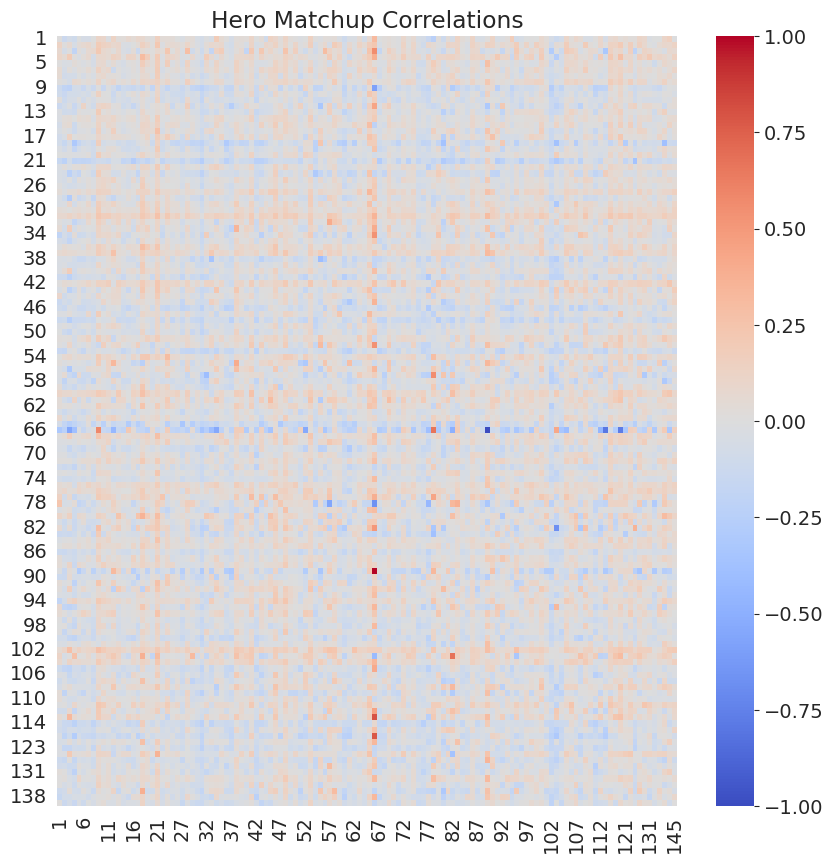

In [ ]:
plt.figure(figsize=(10, 10))
matchups_corr = (hero_matchups_df/hero_matchups_count_df).fillna(0)
sns.heatmap(matchups_corr, cmap="coolwarm")
plt.title("Hero Matchup Correlations")
plt.show()

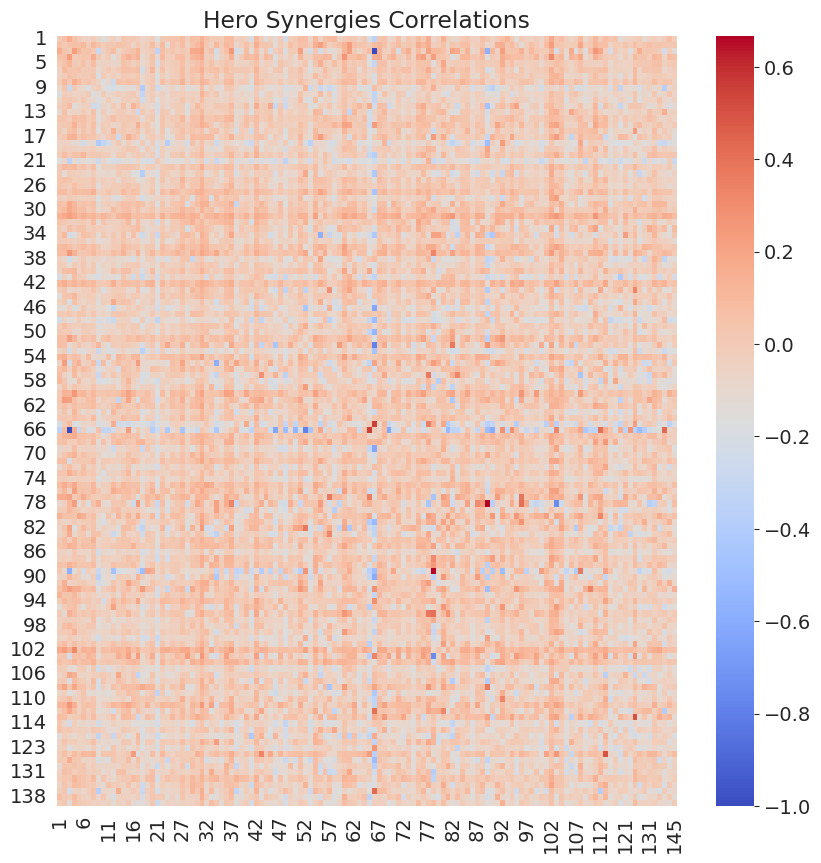

In [ ]:
plt.figure(figsize=(10, 10))
synergies_corr = (hero_synergies_df/hero_synergies_count_df).fillna(0)
sns.heatmap(synergies_corr, cmap="coolwarm")
plt.title("Hero Synergies Correlations")
plt.show()

#### Winrate distribution
The histogram visualizes the **normal distribution of heroes' winrates**, which typically range from **42% to 56%**. This range can vary depending on the patch, as balance changes can make some heroes temporarily too strong or too weak.

- **Outliers**: Heroes with winrates near the extremes (e.g., very high or very low) may reflect imbalance. This could also result in skewness, where one of the tails of the distribution rises instead of falling, a phenomenon known as **positive or negative skew**.
  
- **Smaller Winrate Range**: A smaller range of winrates is desirable, as it indicates better balance. It means each hero has a fair chance to win.

- **Strong Heroes with Low Winrates**: Sometimes, strong heroes may have lower winrates, not due to weakness but because they are **difficult to play effectively**, leading to more misuse by less experienced players.

This visualization provides insights into the current balance state of the game and how heroes perform overall.

<Axes: xlabel='winrate', ylabel='Count'>

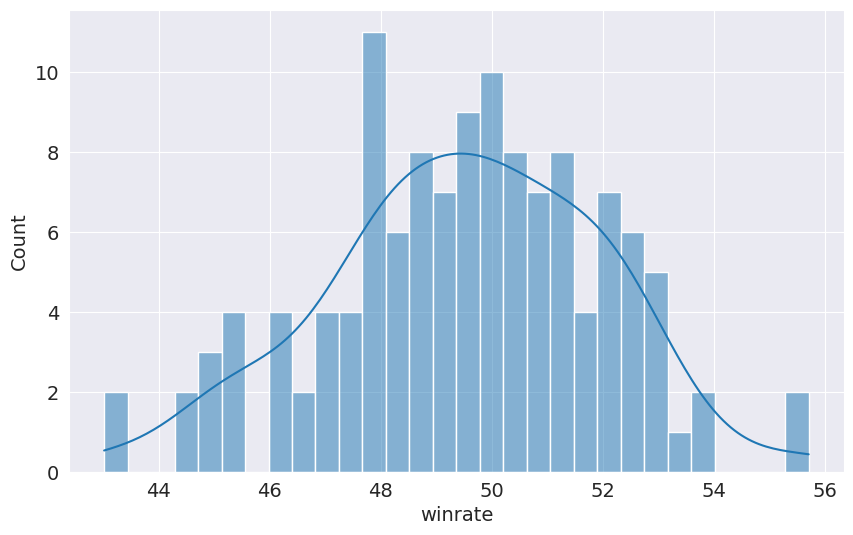

In [ ]:
sns.histplot(data=heroes_df, x="winrate", bins=30, kde=True)

### Analyse of Games Data

In [ ]:
game_id_counts = matches_df["match_id"].value_counts()
duplicate_game_ids = game_id_counts[game_id_counts > 1]

print("Duplicate Game IDs:")
print(duplicate_game_ids)
print("Number of Heroes: ", len(matches_df))

Duplicate Game IDs:
Series([], Name: count, dtype: int64)
Number of Heroes:  199900


In [ ]:
matches_df.head()

,match_id,radiant_team,dire_team,radiant_win,radiant_wr,dire_wr,radiant_matchups_score,dire_matchups_score,radiant_synergies_score,dire_synergies_score
0,8076745617,"[44, 88, 107, 14, 29]","[43, 6, 65, 51, 145]",False,50.450229,49.146502,0.458733,-0.458733,0.215209,-0.413077
1,8076743800,"[55, 84, 54, 56, 30]","[17, 20, 107, 44, 135]",True,51.272602,50.208074,0.436687,-0.436687,0.308625,0.091060
2,8076743003,"[100, 98, 74, 6, 62]","[2, 92, 26, 119, 93]",True,49.051879,50.217237,-0.441662,0.441662,-0.400999,0.035305
3,8076742811,"[90, 88, 99, 16, 8]","[84, 6, 29, 64, 14]",False,49.787963,51.056247,-0.432911,0.432911,-0.070359,0.514535
4,8076742108,"[10, 114, 22, 88, 38]","[6, 84, 97, 136, 17]",False,48.273972,50.127751,-0.854917,0.854917,-0.718638,-0.070900


In [ ]:
matches_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199900 entries, 0 to 199899
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   match_id                 199900 non-null  int64  
 1   radiant_team             199900 non-null  object 
 2   dire_team                199900 non-null  object 
 3   radiant_win              199900 non-null  bool   
 4   radiant_wr               199900 non-null  float64
 5   dire_wr                  199900 non-null  float64
 6   radiant_matchups_score   199900 non-null  float64
 7   dire_matchups_score      199900 non-null  float64
 8   radiant_synergies_score  199900 non-null  float64
 9   dire_synergies_score     199900 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(2)
memory usage: 13.9+ MB


In [ ]:
matches_df.describe()

,match_id,radiant_wr,dire_wr,radiant_matchups_score,dire_matchups_score,radiant_synergies_score,dire_synergies_score
count,1.999000e+05,199900.000000,199900.000000,199900.000000,199900.000000,199900.000000,199900.000000
mean,8.075057e+09,49.998892,50.001056,-0.000469,0.000469,0.000319,-0.000339
std,9.619995e+05,1.034208,1.036261,0.776722,0.776722,0.440965,0.442152
min,8.073419e+09,45.477720,45.347944,-3.781733,-3.458160,-2.233375,-2.240726
25%,8.074227e+09,49.305917,49.303061,-0.527013,-0.526326,-0.294741,-0.296371
50%,8.075037e+09,50.016964,50.018222,-0.001062,0.001062,0.009226,0.007863
75%,8.075908e+09,50.709043,50.713227,0.526326,0.527013,0.304890,0.305066
max,8.076746e+09,53.934962,54.169292,3.458160,3.781733,1.708287,1.909788


#### Radiant and Dire wins distribution

<ipython-input-31-c12b432de356>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=matches_df, x='radiant_win', palette='viridis')


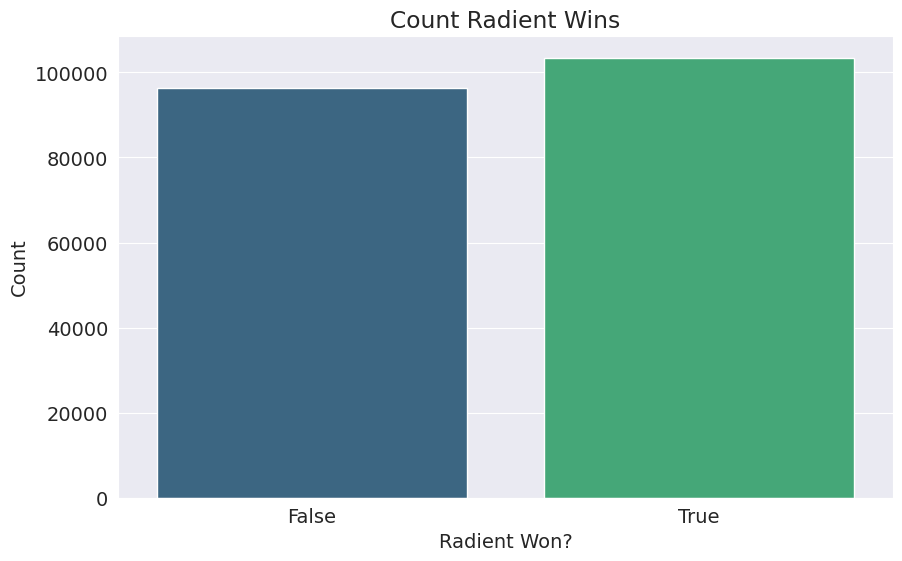

In [ ]:
sns.countplot(data=matches_df, x='radiant_win', palette='viridis')

plt.title('Count Radient Wins')
plt.xlabel('Radient Won?')
plt.ylabel('Count')
plt.show()

In [ ]:
comparison_df = matches_df[['radiant_matchups_score', 'dire_matchups_score', 'radiant_wr', 'dire_wr', 'radiant_win']].copy()
comparison_df['wr_diff'] = comparison_df['radiant_wr'] - comparison_df['dire_wr']
print("Winrate differences:")
print(comparison_df['wr_diff'].describe())


Winrate differences:
count    199900.000000
mean         -0.002164
std           1.482366
min          -6.653222
25%          -1.006649
50%          -0.001652
75%           1.002633
max           6.457191
Name: wr_diff, dtype: float64


#### Win Rate Comparison

Calculates and compares the number of matches where the win rate difference (`wr_diff`) aligns positively or negatively with the match outcome, grouping by Radiant and Dire wins.

In [ ]:
df_team1 = comparison_df[comparison_df["radiant_win"] == True]

pos_wr = len(df_team1[df_team1['wr_diff'] > 0])
neg_wr = len(df_team1[df_team1['wr_diff'] <= 0])

df_team2 = comparison_df[comparison_df["radiant_win"] == False]

pos_wr += len(df_team2[df_team2['wr_diff'] < 0])
neg_wr += len(df_team2[df_team2['wr_diff'] >= 0])

comparison = {
    "Positive WR": pos_wr,
    "Negative WR": neg_wr
}

comparison


{'Positive WR': 111892, 'Negative WR': 88008}

## Preparing Data for Prediction Models

### Defining Input and Target Columns

In this block, we specify the **input features** (`input_cols`) and the **target variable** (`target_col`) for the machine learning model:

- **Input Features (`input_cols`)**: These are the metrics used to predict the outcome of the game:
  - `radiant_wr`: The average win rate of heroes on the Radiant team.
  - `dire_wr`: The average win rate of heroes on the Dire team.
  - `radiant_matchups_score`: The score reflecting how well the Radiant heroes counter the Dire heroes.
  - `dire_matchups_score`: The score reflecting how well the Dire heroes counter the Radiant heroes.
  - `radiant_synergies_score`: The synergy score within the Radiant team.
  - `dire_synergies_score`: The synergy score within the Dire team.

- **Target Variable (`target_col`)**: This is the outcome we aim to predict (`radiant_win`), indicating whether the **Radiant team** or the **Dire team** won the game.

This setup ensures the model learns from hero win rates, counter matchups, and team synergies to make accurate predictions.

In [ ]:
matches_df.head()

,match_id,radiant_team,dire_team,radiant_win,radiant_wr,dire_wr,radiant_matchups_score,dire_matchups_score,radiant_synergies_score,dire_synergies_score
0,8076745617,"[44, 88, 107, 14, 29]","[43, 6, 65, 51, 145]",False,50.450229,49.146502,0.458733,-0.458733,0.215209,-0.413077
1,8076743800,"[55, 84, 54, 56, 30]","[17, 20, 107, 44, 135]",True,51.272602,50.208074,0.436687,-0.436687,0.308625,0.091060
2,8076743003,"[100, 98, 74, 6, 62]","[2, 92, 26, 119, 93]",True,49.051879,50.217237,-0.441662,0.441662,-0.400999,0.035305
3,8076742811,"[90, 88, 99, 16, 8]","[84, 6, 29, 64, 14]",False,49.787963,51.056247,-0.432911,0.432911,-0.070359,0.514535
4,8076742108,"[10, 114, 22, 88, 38]","[6, 84, 97, 136, 17]",False,48.273972,50.127751,-0.854917,0.854917,-0.718638,-0.070900


In [ ]:
input_cols = ['radiant_wr', 'dire_wr', 'radiant_matchups_score', 'dire_matchups_score', 'radiant_synergies_score', 'dire_synergies_score']
target_col = 'radiant_win'

#### Splitting the Data into Training and Testing Sets

This step divides the dataset into **training** (80%) and **testing** (20%) subsets using `train_test_split`. This ensures that the model is trained on one portion of the data and tested on a separate portion to evaluate its performance.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(matches_df[input_cols], matches_df[target_col], test_size=0.2, random_state=42)
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

#### Data Preprocessing: Imputation and Scaling

This block preprocesses the data in two steps to prepare it for model training:

1. **Imputation with SimpleImputer**:
   - Handles missing values by replacing them with the **mean** of each column in the training set.
   - Even though there are no missing values in this dataset (since it was created manually), this step is included as a precaution.

2. **Feature Scaling with MinMaxScaler**:
   - Scales features to a range of **0 to 1** to normalize the data.
   - Prevents features with large ranges from dominating the model's performance.

These steps standardize the data and ensure it's robust and ready for machine learning algorithms.

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Comparing Simple Prediction Strategies

This section explores three different strategies for predicting the winning team and evaluates their performance:

1. **Random Prediction (`compare_flip_coin`)**:
   - Simulates a coin flip to randomly assign a winner between "team1" and "team2".
   - Incorporates a random seed for reproducibility.

2. **Win Rate-Based Prediction (`compare_wr`)**:
   - Compares the win rates of both teams.
   - Predicts "team1" if its win rate is equal to or greater than "team2"; otherwise, predicts "team2".

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
import random
def compare_flip_coin(inputs, seed=None):

    if seed is not None:
        random.seed(seed)

    predictions = []

    for i in inputs:
        if random.randint(0, 1) == 1:

            predictions.append(True)
            continue
        predictions.append(False)
    return predictions


In [ ]:
predictions = pd.DataFrame({"radiant_win": compare_flip_coin(X_train, seed=42)})
predictions_series = predictions["radiant_win"].astype(bool)
accuracy = accuracy_score(y_train, predictions_series)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.50


In [ ]:
def compare_wr(inputs):
  pd_inputs = pd.DataFrame(inputs, columns=input_cols)
  predictions = []

  for _, row in pd_inputs.iterrows():
    if row["radiant_wr"] >= row["dire_wr"]:
      predictions.append(True)
      continue
    predictions.append(False)
  return predictions


In [ ]:
predictions = pd.DataFrame({"radiant_win": compare_wr(X_train)})
predictions_series = predictions["radiant_win"].astype(bool)
accuracy = accuracy_score(y_train, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.56


### Random Forest Classifier

The **Random Forest Classifier (RFC)** works by creating multiple decision trees on random subsets of data and features, then combining their outputs to make a final prediction, reducing overfitting and improving accuracy.

#### Why it Fits Our Data
RFC is ideal for our dataset because:
- It handles non-linear relationships between hero matchups, win rates, and outcomes.
- It’s robust to noisy data, which is crucial given the variability in hero interactions.
- It provides feature importance, helping us understand which factors (e.g., win rate or score) impact predictions the most.

This makes it a strong choice for predicting match outcomes based on hero picks.

[More about RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=42)

In [ ]:
train_preds = rfc.predict(X_test)
accuracy = accuracy_score(y_test, train_preds)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.59


#### Evaluating the Impact of `n_estimators`

This block evaluates how the number of decision trees (`n_estimators`) in a Random Forest Classifier affects its performance. For each value of `n_estimators` from 1 to 99:
- The model is trained and tested.
- **Test Accuracy**: Measures the model's performance on unseen data.
- **Train Accuracy**: Measures performance on the training set, indicating overfitting if too high.

The results are visualized in a plot showing how increasing the number of trees impacts the accuracies. This helps identify an optimal value for `n_estimators` where the model balances generalization and accuracy.

In [ ]:
def best_n_estimator(n_estimator):
  rfc = RandomForestClassifier(n_estimators=n_estimator, random_state=42)
  rfc.fit(X_train, y_train)
  train_preds = rfc.predict(X_test)
  test_preds = rfc.predict(X_train)
  return {"N Estimators": n_estimator, "Test Accuracy": accuracy_score(y_test, train_preds), "Train Accuracy": accuracy_score(y_train, test_preds)}

In [ ]:
%%time
accuracie_df = pd.DataFrame([best_n_estimator(i) for i in range(1, 100)])

CPU times: user 1h 20min 36s, sys: 25.1 s, total: 1h 21min 1s
Wall time: 1h 21min 29s


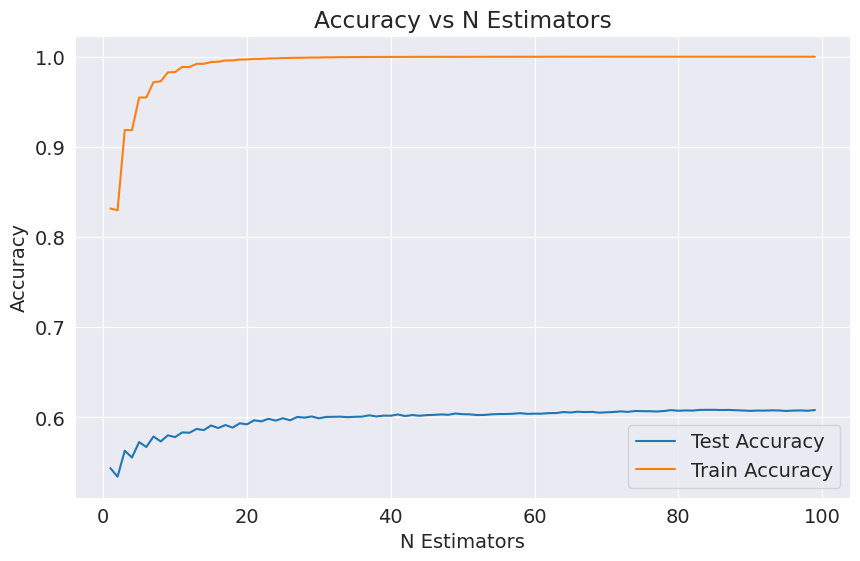

In [ ]:
plt.plot(accuracie_df["N Estimators"], accuracie_df["Test Accuracy"], label="Test Accuracy")
plt.plot(accuracie_df["N Estimators"], accuracie_df["Train Accuracy"], label="Train Accuracy")
plt.xlabel("N Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs N Estimators")
plt.legend()
plt.show()

In [ ]:
accuracie_df.sort_values(by="Test Accuracy", ascending=False).head()

,N Estimators,Test Accuracy,Train Accuracy
83,84,0.608429,1.0
84,85,0.608429,1.0
82,83,0.608329,1.0
86,87,0.608304,1.0
85,86,0.608204,1.0


#### Analyzing Optimal Hyperparameters

This block focuses on finding the best configuration of hyperparameters for the Random Forest model, specifically the number of estimators (`n_estimators`).

- The function `best_n_estimator` trains the model with a specified number of decision trees, evaluating its performance on both training and test datasets.
- A range of values (1 to 99) for `n_estimators` is tested.
- **Train Accuracy** and **Test Accuracy** are calculated for each configuration and stored in a DataFrame.

The generated plot compares training and test accuracy as the number of estimators increases, revealing trends in model performance and identifying the point where adding more trees no longer improves generalization. This approach ensures the model is efficient without overfitting.

In [ ]:
%%time
def evaluate_model(n_estimators, max_depth, max_features):
    rfc = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42
    )
    rfc.fit(X_train, y_train)
    test_preds = rfc.predict(X_test)
    train_preds = rfc.predict(X_train)
    return {
        "N Estimators": n_estimators,
        "Max Depth": max_depth,
        "Max Features": max_features,
        "Test Accuracy": accuracy_score(y_test, test_preds),
        "Train Accuracy": accuracy_score(y_train, train_preds)
    }

param_grid = [
    (n, d, f)
    for n in range(10, 101, 10)
    for d in range(1, 21, 5)
    for f in range(1, X_train.shape[1] + 1, 2)
]

results = [evaluate_model(n, d, f) for n, d, f in param_grid]

results_df = pd.DataFrame(results)

fig = px.scatter_3d(
    results_df,
    x="N Estimators",
    y="Max Depth",
    z="Max Features",
    color="Test Accuracy",
    size="Test Accuracy",
    title="Hyperparameter Tuning Results",
    labels={"N Estimators": "N Estimators", "Max Depth": "Max Depth", "Max Features": "Max Features"}
)
fig.show()

CPU times: user 1h 9min 10s, sys: 3.23 s, total: 1h 9min 13s
Wall time: 1h 9min 43s


In [ ]:
best_rf_params = results_df.loc[results_df["Test Accuracy"].idxmax()]
print("Best Random Forest Hyperparameters: ", best_rf_params.to_dict())

Best Random Forest Hyperparameters:  {'N Estimators': 50.0, 'Max Depth': 11.0, 'Max Features': 5.0, 'Test Accuracy': 0.6256378189094547, 'Train Accuracy': 0.6836918459229615}


In [ ]:
n_estimators = int(best_rf_params.to_dict()["N Estimators"])
max_depth = int(best_rf_params.to_dict()["Max Depth"])
max_features = int(best_rf_params.to_dict()["Max Features"])

rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, max_features=5, n_estimators=50,
                       random_state=42)

In [ ]:
importance_df = pd.DataFrame({
    "Feature": input_cols,
    "Importance": rfc.feature_importances_
}).sort_values(by="Importance", ascending=False)
importance_df

,Feature,Importance
3,dire_matchups_score,0.195631
2,radiant_matchups_score,0.180377
1,dire_wr,0.175585
0,radiant_wr,0.174563
5,dire_synergies_score,0.138851
4,radiant_synergies_score,0.134993


### Gradient Boosting Hyperparameter Tuning

This block explores the optimal hyperparameters for a **Gradient Boosting Classifier**, a powerful ensemble learning method that builds models sequentially to correct errors made by prior models.

- **Key Parameters Tuned**:
  - `n_estimators`: Number of boosting stages (range: 10–100).
  - `max_depth`: Maximum depth of each tree (range: 1–10).
  - `learning_rate`: Shrinks the contribution of each tree (values: 0.01, 0.1, 0.2).

- **Process**:
  - The `evaluate_gb_model` function calculates the accuracy of the model on both training and test sets for each combination of parameters.
  - Results are stored in a DataFrame and visualized in a 3D scatter plot, showing how different hyperparameters influence **Test Accuracy**.

- **Why Gradient Boosting?**:
  Gradient Boosting works well with tabular data and provides strong performance by iteratively correcting mistakes. It’s particularly suited for datasets where capturing subtle patterns is crucial, such as this one with hero matchups and scores.

The optimal configuration is determined by selecting the hyperparameters with the highest test accuracy, ensuring balance between accuracy and generalization.

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

def evaluate_gb_model(n_estimators, max_depth, learning_rate):
    gbc = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42
    )
    gbc.fit(X_train, y_train)
    test_preds = gbc.predict(X_test)
    train_preds = gbc.predict(X_train)
    return {
        "N Estimators": n_estimators,
        "Max Depth": max_depth,
        "Learning Rate": learning_rate,
        "Test Accuracy": accuracy_score(y_test, test_preds),
        "Train Accuracy": accuracy_score(y_train, train_preds)
    }

param_grid_gb = [
    (n, d, lr)
    for n in range(10, 101, 10)
    for d in range(1, 11, 2)
    for lr in [0.01, 0.1, 0.2]
]

results_gb = [evaluate_gb_model(n, d, lr) for n, d, lr in param_grid_gb]

results_gb_df = pd.DataFrame(results_gb)

fig_gb = px.scatter_3d(
    results_gb_df,
    x="N Estimators",
    y="Max Depth",
    z="Learning Rate",
    color="Test Accuracy",
    size="Test Accuracy",
    title="Gradient Boosting Hyperparameter Tuning",
    labels={"N Estimators": "N Estimators", "Max Depth": "Max Depth", "Learning Rate": "Learning Rate"}
)
fig_gb.show()

CPU times: user 2h 51min 15s, sys: 6.08 s, total: 2h 51min 21s
Wall time: 2h 52min 44s


In [ ]:
best_gb_params = results_gb_df.loc[results_gb_df["Test Accuracy"].idxmax()]
print("Best Gradient Boosting Hyperparameters: ", best_gb_params.to_dict())

Best Gradient Boosting Hyperparameters:  {'N Estimators': 100.0, 'Max Depth': 7.0, 'Learning Rate': 0.1, 'Test Accuracy': 0.6298649324662331, 'Train Accuracy': 0.6720360180090045}


### Logistic Regression Hyperparameter Tuning

This block focuses on identifying the best hyperparameters for **Logistic Regression**, a simple yet effective model for binary classification. Logistic Regression is especially suitable for interpreting the relationships between input features and the target variable, making it ideal for this project’s focus on hero matchups and team synergies.

- **Key Parameters Tuned**:
  - `penalty`: The type of regularization applied (`l1`, `l2`, `elasticnet`, or `none`).
  - `C`: Inverse of regularization strength (values: 0.01, 0.1, 1, 10, 100).
  - `solver`: Optimization algorithm used (`liblinear`, `saga`, or `lbfgs`).

- **Process**:
  - The `evaluate_logistic_model` function computes the model’s performance on both training and test datasets for each parameter combination.
  - Results are stored in a DataFrame and visualized in a 3D scatter plot, providing insights into how different configurations affect **Test Accuracy**.

- **Why Logistic Regression?**:
  Logistic Regression provides a balance between interpretability and predictive power. Its straightforward structure allows for easy understanding of how hero performance metrics like win rates and matchup scores contribute to match outcomes.

The best hyperparameters are chosen based on the highest test accuracy, ensuring a model that generalizes well while maintaining interpretability.

In [ ]:
from sklearn.linear_model import LogisticRegression

def evaluate_logistic_model(C, solver, max_iter):
    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter, random_state=42)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    train_preds = model.predict(X_train)
    return {
        "C": C,
        "Solver": solver,
        "Max Iter": max_iter,
        "Test Accuracy": accuracy_score(y_test, test_preds),
        "Train Accuracy": accuracy_score(y_train, train_preds)
    }

C_values = [0.01, 0.1, 1, 10, 100]
solvers = ['lbfgs', 'liblinear', 'saga']
max_iters = [100, 200, 300]

param_grid = [
    (C, solver, max_iter)
    for C in C_values
    for solver in solvers
    for max_iter in max_iters
]

results = [evaluate_logistic_model(C, solver, max_iter) for C, solver, max_iter in param_grid]

results_df = pd.DataFrame(results)

fig = px.scatter_3d(
    results_df,
    x="C",
    y="Max Iter",
    z="Solver",
    color="Test Accuracy",
    size="Test Accuracy",
    title="Hyperparameter Tuning Results for Logistic Regression",
    labels={"C": "C (Regularization)", "Max Iter": "Max Iterations", "Solver": "Solver"}
)
fig.show()

In [ ]:
best_logistic_params = results_df.loc[results_df["Test Accuracy"].idxmax()]
print("Best Logic Regression Hyperparameters: ", best_logistic_params.to_dict())

Best Logic Regression Hyperparameters:  {'C': 100.0, 'Solver': 'lbfgs', 'Max Iter': 100, 'Test Accuracy': 0.6368684342171086, 'Train Accuracy': 0.6365120060030015}


## Match Outcome Prediction for Selected Picks

This section demonstrates predicting the winner of a match based on two pre-defined teams of heroes. The **Radiant** and **Dire** teams are specified by hero names, which are converted into their corresponding IDs using a helper function. The prediction model then analyzes the matchups, synergies, and win rates of the selected heroes to determine the likely winner and the confidence of the prediction.

In [ ]:
def predict_winner(radiant_team, dire_team, heroes_df, hero_matchups_df, hero_matchups_count_df, hero_synergies_df, hero_synergies_count_df, rfc):
    valid_radiant_team = [hero for hero in radiant_team if hero in hero_matchups_df.index]
    valid_dire_team = [hero for hero in dire_team if hero in hero_matchups_df.index]

    if len(valid_radiant_team) < 5 or len(valid_dire_team) < 5:
        raise ValueError("Each team must have 5 valid heroes.")

    test_match = {
        "match_id": 1,
        "radiant_team": valid_radiant_team,
        "dire_team": valid_dire_team,
        "radiant_wr": 0,
        "dire_wr": 0,
        "radiant_matchups_score": 0,
        "dire_matchups_score": 0,
        "radiant_synergies_score": 0,
        "dire_synergies_score": 0,
        "radiant_win": None
    }

    test_matches_df = pd.DataFrame([test_match])

    process_match_data(
        matches_df=test_matches_df,
        heroes_df=heroes_df,
        hero_matchups_df=hero_matchups_df,
        hero_matchups_count_df=hero_matchups_count_df,
        hero_synergies_df=hero_synergies_df,
        hero_synergies_count_df=hero_synergies_count_df
    )

    input_data = test_matches_df[['radiant_wr', 'dire_wr', 'radiant_matchups_score', 'dire_matchups_score', 'radiant_synergies_score', 'dire_synergies_score']]

    prediction = rfc.predict(input_data)
    probabilities = rfc.predict_proba(input_data)

    winner = "Radiant" if prediction[0] else "Dire"
    confidence = max(probabilities[0]) * 100

    return winner, confidence


In [ ]:
def hero_names_to_ids(hero_names, heroes_df):
    hero_ids = []
    for name in hero_names:
        hero_id = heroes_df[heroes_df["name"] == name]["id"]
        if not hero_id.empty:
            hero_ids.append(hero_id.values[0])
        else:
            raise ValueError(f"Hero name '{name}' not found in the heroes_df.")
    return hero_ids


In [ ]:
radiant_team_names = ["Anti-Mage", "Crystal Maiden", "Invoker", "Axe", "Lina"]
dire_team_names = ["Pudge", "Shadow Fiend", "Drow Ranger", "Juggernaut", "Vengeful Spirit"]

radiant_team = hero_names_to_ids(radiant_team_names, heroes_df)
dire_team = hero_names_to_ids(dire_team_names, heroes_df)

print("Radiant Team:")
for hero in radiant_team_names:
    print(hero)
print("\n-------------------------------\n")
print("Dire Team:")
for hero in dire_team_names:
    print(hero)

winner, confidence = predict_winner(
    radiant_team=radiant_team,
    dire_team=dire_team,
    heroes_df=heroes_df,
    hero_matchups_df=hero_matchups_df,
    hero_matchups_count_df=hero_matchups_count_df,
    hero_synergies_df=hero_synergies_df,
    hero_synergies_count_df=hero_synergies_count_df,
    rfc=rfc
)

print(f"\nPredicted winner: {winner} with confidence: {confidence:.2f}%")


Radiant Team:
Anti-Mage
Crystal Maiden
Invoker
Axe
Lina

-------------------------------

Dire Team:
Pudge
Shadow Fiend
Drow Ranger
Juggernaut
Vengeful Spirit

Predicted winner: Radiant with confidence: 50.76%


<ipython-input-12-0e83f9ccd315>:61: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.18597056061872' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-12-0e83f9ccd315>:62: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50.3472070533379' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-12-0e83f9ccd315>:63: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.236560143675909' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-12-0e83f9ccd315>:64: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2365601436759

In [ ]:
%cd /content/

/content


In [ ]:
#!zip -r data.zip data/